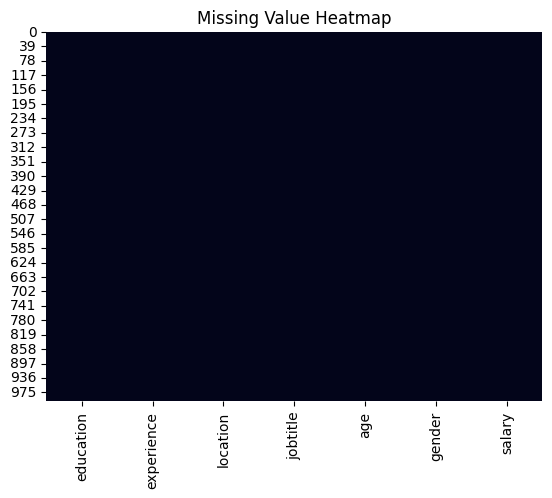

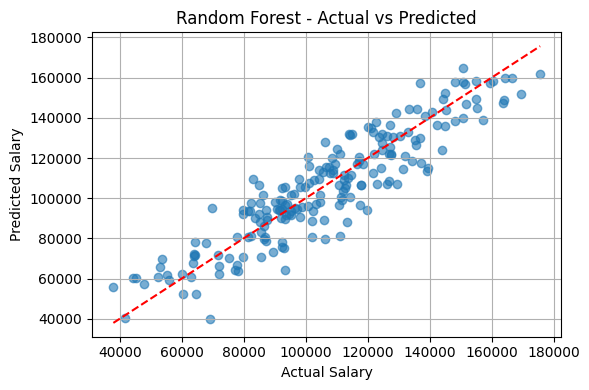

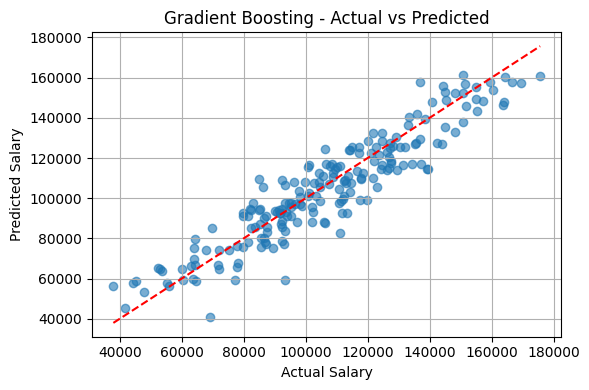

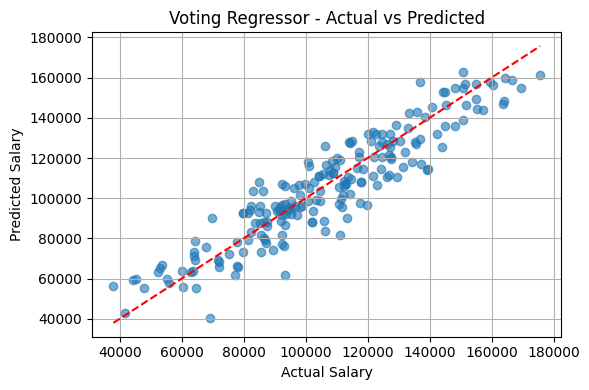


Model Performance Summary:
               Model          RMSE          MAE        R²
1  Gradient Boosting  10528.932684  8466.809553  0.864232
2   Voting Regressor  10898.222192  8811.650388  0.854541
0      Random Forest  11750.556237  9565.398027  0.830899

Best Random Forest Params: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Best RF Cross-validated RMSE: 11184.040568949376

Model saved as 'salary_prediction_model.pkl'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import joblib

# Step 1: Load and clean data
df = pd.read_csv('D:/PBEL Project/salary_prediction_data.csv')

# Clean column names
df.columns = df.columns.str.strip().str.replace(' ', '').str.replace('-', '').str.lower()

# Visualize missing data (optional)
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()

# Drop rows with missing values in relevant columns
required_columns = ['salary', 'jobtitle', 'experience', 'education', 'location']
df.dropna(subset=required_columns, inplace=True)

# Step 2: Feature selection
categorical_features = ['jobtitle', 'education', 'location']
numerical_features = ['experience']
X = df[categorical_features + numerical_features]
y = df['salary']

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', make_pipeline(StandardScaler()), numerical_features)
])

# Step 5: Models
# Random Forest
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Gradient Boosting
gb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

# Voting Regressor
voting_regressor = VotingRegressor(estimators=[
    ('rf', rf),
    ('gb', gb)
])

models = {
    'Random Forest': rf,
    'Gradient Boosting': gb,
    'Voting Regressor': voting_regressor
}

# Step 6: Evaluation
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'R²': r2})

    # Plot predictions
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, preds, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Salary")
    plt.ylabel("Predicted Salary")
    plt.title(f"{name} - Actual vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 7: Show results
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(results_df.sort_values(by='RMSE'))

# Step 8: Hyperparameter tuning for Random Forest (Optional)
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(rf, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("\nBest Random Forest Params:", grid_rf.best_params_)
print("Best RF Cross-validated RMSE:", -grid_rf.best_score_)

# Step 9: Save best model (Voting Regressor)
joblib.dump(voting_regressor, 'salary_prediction_model.pkl')
